# Visualising Data

**Authors:**

- [Angus Mackenzie](https://github.com/AngusTheMack) ([1106817](mailto:1106817@students.wits.ac.za))
- [Nathan Michlo](https://github.com/nmichlo) ([1386161](mailto:1386161@students.wits.ac.za))

**Achievement** Using various CNN visualisation techniques we examine how our trained models interect with the input images.

## Introduction
This notebook is based off of techniques from [Pytorch CNN Visualisations](https://github.com/utkuozbulak/pytorch-cnn-visualizations).

----------------------

# Code - Init

**Imports**

In [153]:
# Utilities
import sys
import os
import fastai
import torch
import tqdm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

# Machine Learning
import torch
import torchvision
from torchvision import transforms
import pytorch_lightning as pl
from torch import optim
from fastai.vision import *
from fastai.metrics import accuracy
from fastai.basic_data import *
from fastai.callbacks.hooks import num_features_model
from efficientnet_pytorch import EfficientNet
from tqdm import tqdm_notebook as tqdm


# Add root of project to PYTHON_PATH so we can import correctly
if os.path.abspath('../') not in {os.path.abspath(path) for path in sys.path}:
    sys.path.insert(0, os.path.abspath('../'))

**SSIC common**

In [2]:
# Import SSIC common stuffs
from ssic.ssic import SSIC
from ssic.util import set_random_seed

# if you dont have a .env file set it here
os.environ.setdefault('DATASET_DIR', '~/downloads/datasets/ssic')

# Initialise SSIC paths, data and other stuffs, searches for a .env file in the project with these variables specified, also checkpoints os.environ and sys.path
SSIC.init()

# SSIC.init is required to locate these imports
from ranger import Ranger
from radam import RAdam
from lookahead import Lookahead
from Mish.Torch.functional import mish
from Mish.Torch.mish import Mish

[LOADED]: 
[STORAGE_DIR]: /home/nmichlo/workspace/snake-id/notebooks/out
[DATASET_DIR]: /home/nmichlo/downloads/datasets/ssic
[DATASET_CLASS_CSV]: /home/nmichlo/downloads/datasets/ssic/class_idx_mapping.csv
[DATASET_TRAIN_DIR]: /home/nmichlo/downloads/datasets/ssic/train
[DATASET_TEST_DIR]: /home/nmichlo/downloads/datasets/ssic/round1


**Util**

In [188]:
from IPython import display

def plt_show_loop():
    # same as plt.show() but cleares all output in the block
    display.display(plt.gcf())
    display.clear_output(wait=True)

-----------------------
# Code - Model

In [128]:
set_random_seed(42)

[SEEDED]: 42


**Create Model**

In [133]:
model_name = 'efficientnet-b0'
save_learner = f'{SSIC.STORAGE_DIR}/{model_name}'

def make_model():
    # Create Model
    model = EfficientNet.from_pretrained(model_name)
    # Add Additional Output Layers
    model.add_module('_fc', nn.Linear(1280, SSIC.num_classes))
    return model

model = make_model()

Loaded pretrained weights for efficientnet-b0


**Create ImageList**

In [131]:
# get the dataset
imagelist = SSIC.get_train_imagelist(0.2)

# get input image size
image_size = EfficientNet.get_image_size(model_name)
print(f'Image size: {image_size} x {image_size} x Channels')

# apply transforms
imagelist = imagelist.transform(
    # tfms=([rotate(degrees=(-90,90), p=1)], []),                               # OLD TRANSFORMS
    tfms=get_transforms(do_flip=True, flip_vert=False, max_rotate=90), #, xtra_tfms=[normalize(*imagenet_stats)]),  # NEW TRANSFORMS
    size=image_size,
    resize_method=ResizeMethod.SQUISH,
)

def get_random_img():
    return imagelist.train[random.randint(0, len(imagelist.train))][0]

Image size: 224 x 224 x Channels


**Create ImageBatch**

In [138]:
# # batch and normalise
# data = imagelist.databunch(bs=32).normalize(imagenet_stats)

# # visualise
# data.show_batch(3, figsize=(5, 5))

**Create Learner & Train**

In [132]:
# # >>> CHOOSE OPTIMIZER
# opt_func = partial(torch.optim.RMSprop),
# opt_func = partial(Ranger),
# opt_func = partial(RAdam)

# # Create learner
# learn = Learner(
#     data, model,
#     loss_func=LabelSmoothingCrossEntropy(),
#     opt_func=opt_func,
#     metrics=[accuracy, FBeta(beta=1, average='macro')]
# )

# # Create subgroups within the model, WHY? Seems to work without this...
# learn.split([
#     [learn.model._conv_stem, learn.model._bn0, learn.model._blocks[:8]],
#     [learn.model._blocks[8:], learn.model._conv_head], 
#     [learn.model._bn1, learn.model._fc]]
# )

# learn = learn.to_fp16()

# learn.fit(40, lr=1e-3, wd=1e-5)
# learn.fit_one_cycle(40, max_lr=slice(lr/100,lr))  # should not use with RAdam

# saved_learner = learner.save(save_learner, return_path=True) # saves model & opts, so access model with pytorch.load(...)['model']

-----------------------------
# Model Visualisations

**1. Visualisation: Class Specific Image Generation**

In [155]:
from cnn_layer_visualization import CNNLayerVisualization
from deep_dream import DeepDream
from generate_class_specific_samples import ClassSpecificImageGeneration
from gradcam import GradCam
from guided_backprop import GuidedBackprop
from misc_functions import preprocess_image, recreate_image, save_image

In [403]:
def generate_class_specific_image(model, target_class, steps=75, lr=5, weight_decay=5e-3, random=False):
    if random:
        processed_image = np.uint8(np.random.uniform(0, 255, (224, 224, 3)))
        processed_image = preprocess_image(processed_image, False)
    else:
        processed_image = get_random_img().data[None,...]

    # evaluation mode
    model.eval()

    # optimise image iteratively
    for i in tqdm(range(steps), 'Generating Image'):
        try:
            # define optimizer over the image | need to do this each time because the image is re-created
            # optimizer = RAdam([processed_image], lr=lr, weight_decay=weight_decay)
            optimizer = torch.optim.SGD([processed_image], lr=lr, weight_decay=weight_decay)

            # forward & get loss for specific class
            output = model(processed_image)
            class_loss = - output[0, target_class]

            # Optimize Step
            model.zero_grad()
            class_loss.backward()
            optimizer.step()
    
            # Generate human image
            generated_image = recreate_image(processed_image)
            processed_image = preprocess_image(generated_image, False)
            
            # Display Image & INFO
            plt.imshow(generated_image)
            plt.title(f'Class: {target_class} Iteration: {i} Loss {class_loss.data.numpy():.2f}')
            plt_show_loop()
        except KeyboardInterrupt:
            break
    return generated_image

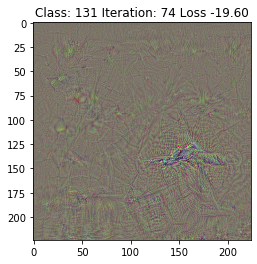

In [408]:
# Pretrained Imagenet:
model = EfficientNet.from_pretrained(model_name)
# model = torchvision.models.resnet18(pretrained=True)
# model = torchvision.models.alexnet(pretrained=True)

# 130 - flamingo
img = generate_class_specific_image(model, 131, lr=5, weight_decay=1e-2, random=True)

In [405]:
# LOAD MODEL
model = make_model()
model.load_state_dict(torch.load(f'vanilla_b0_efficientnet/b0-trained-for-40.pth')['model'])

class_spcecific_images = [
    generate_class_specific_image(model, i, lr=5, weight_decay=1e-2, random=True)
    for i in tqdm(range(SSIC.num_classes))
]

Loaded pretrained weights for efficientnet-b0


<All keys matched successfully>

**2. Occlusion**

In [409]:
def occlusion_sensitivity(
    model, images, ids, mean=None, patch=35, stride=1, n_batches=128
):
    """
    "Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization"
    https://arxiv.org/pdf/1610.02391.pdf
    Look at Figure A5 on page 17
    
    Originally proposed in:
    "Visualizing and Understanding Convolutional Networks"
    https://arxiv.org/abs/1311.2901
    """

    torch.set_grad_enabled(False)
    model.eval()
    mean = mean if mean else 0
    patch_H, patch_W = patch if isinstance(patch, Sequence) else (patch, patch)
    pad_H, pad_W = patch_H // 2, patch_W // 2

    # Padded image
    images = F.pad(images, (pad_W, pad_W, pad_H, pad_H), value=mean)
    B, _, H, W = images.shape
    new_H = (H - patch_H) // stride + 1
    new_W = (W - patch_W) // stride + 1

    # Prepare sampling grids
    anchors = []
    grid_h = 0
    while grid_h <= H - patch_H:
        grid_w = 0
        while grid_w <= W - patch_W:
            grid_w += stride
            anchors.append((grid_h, grid_w))
        grid_h += stride

    # Baseline score without occlusion
    baseline = model(images).detach().gather(1, ids)

    # Compute per-pixel logits
    scoremaps = []
    for i in tqdm(range(0, len(anchors), n_batches), leave=False):
        batch_images = []
        batch_ids = []
        for grid_h, grid_w in anchors[i : i + n_batches]:
            images_ = images.clone()
            images_[..., grid_h : grid_h + patch_H, grid_w : grid_w + patch_W] = mean
            batch_images.append(images_)
            batch_ids.append(ids)
        batch_images = torch.cat(batch_images, dim=0)
        batch_ids = torch.cat(batch_ids, dim=0)
        scores = model(batch_images).detach().gather(1, batch_ids)
        scoremaps += list(torch.split(scores, B))

    diffmaps = torch.cat(scoremaps, dim=1) - baseline
    diffmaps = diffmaps.view(B, new_H, new_W)

    return diffmaps

In [414]:
model = torchvision.models.alexnet(pretrained=True)
diffmaps = occlusion_sensitivity(model, get_random_img().data[None, ...], torch.IntTensor([]))

RuntimeError: Expected object of scalar type Long but got scalar type Int for argument #3 'index'

-----------------------
# Code - Visualisations

## 1. Class Specific Image Generation